In [6]:
import pandas as pd
import scanpy as sc
import numpy as np

## load scrna data - already filtered to CD8, Post, responders - 4,420 cells
adata = sc.read_csv("BBC_CD8_post_yes2.csv", delimiter ="," , first_column_names=True)
## clinical and TCR annotation
meta = pd.read_csv("BBC_CD8_pos_meta (1).csv", delimiter =",", index_col=0)
adata = adata.transpose()
adata.obs = meta


In [7]:
adata.layers["counts"] = adata.X.copy()

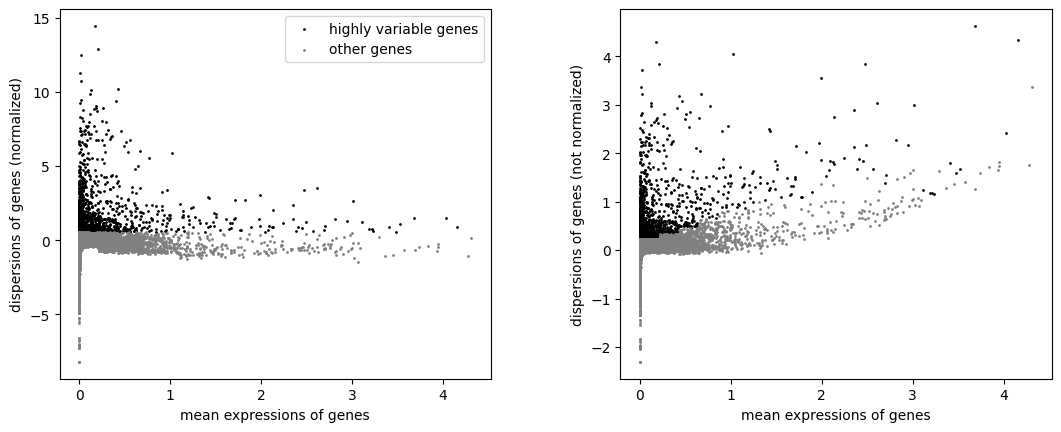

In [8]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)
sc.tl.pca(adata)




In [9]:
adata2 = adata
# use harmony intgration to reduce batch, sex effects
sc.external.pp.harmony_integrate(adata2, "orig.ident", basis='X_pca', adjusted_basis='X_pca_harmony')

2024-08-08 03:02:34,732 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-08 03:02:36,339 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-08 03:02:36,365 - harmonypy - INFO - Iteration 1 of 10
2024-08-08 03:02:37,054 - harmonypy - INFO - Iteration 2 of 10
2024-08-08 03:02:37,734 - harmonypy - INFO - Converged after 2 iterations


In [10]:
adata2.obsm['X_pca'] = adata2.obsm['X_pca_harmony']
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata2)
sc.tl.leiden(adata2, resolution=0.9)

2024-08-08 03:02:56.389055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 03:02:57.330287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_1163480/3443213312.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata2, resolution=0.9)


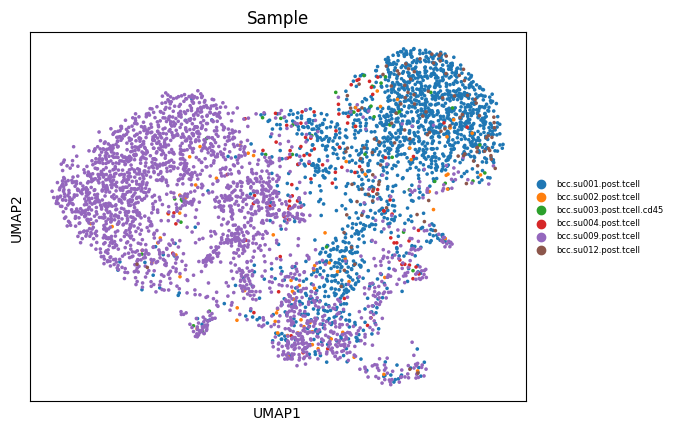

In [33]:
# Annotae cells by sample
donor_umap = sc.pl.umap(adata, color=['orig.ident'],
    show=False, 
legend_fontsize=6, frameon=True, title='Sample')

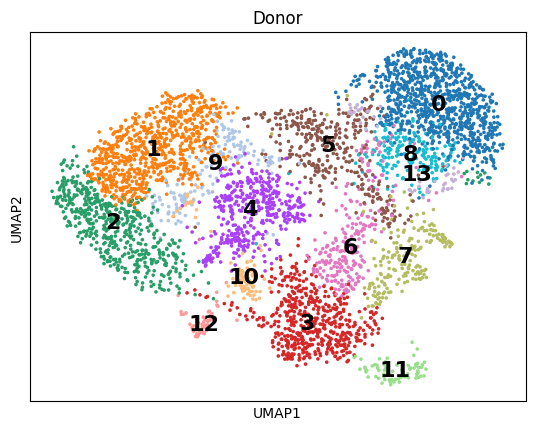

In [22]:
# clusters
donor_umap = sc.pl.umap(adata2, color=['leiden'],
    legend_fontsize=16,
                        legend_loc = "on data", frameon=True, title='Donor')

In [13]:
# Obtain cluster-specific differentially expressed genes
# compare each cluster to all others to idnetify cluster markers
sc.tl.rank_genes_groups(adata2, groupby="leiden", method="wilcoxon")

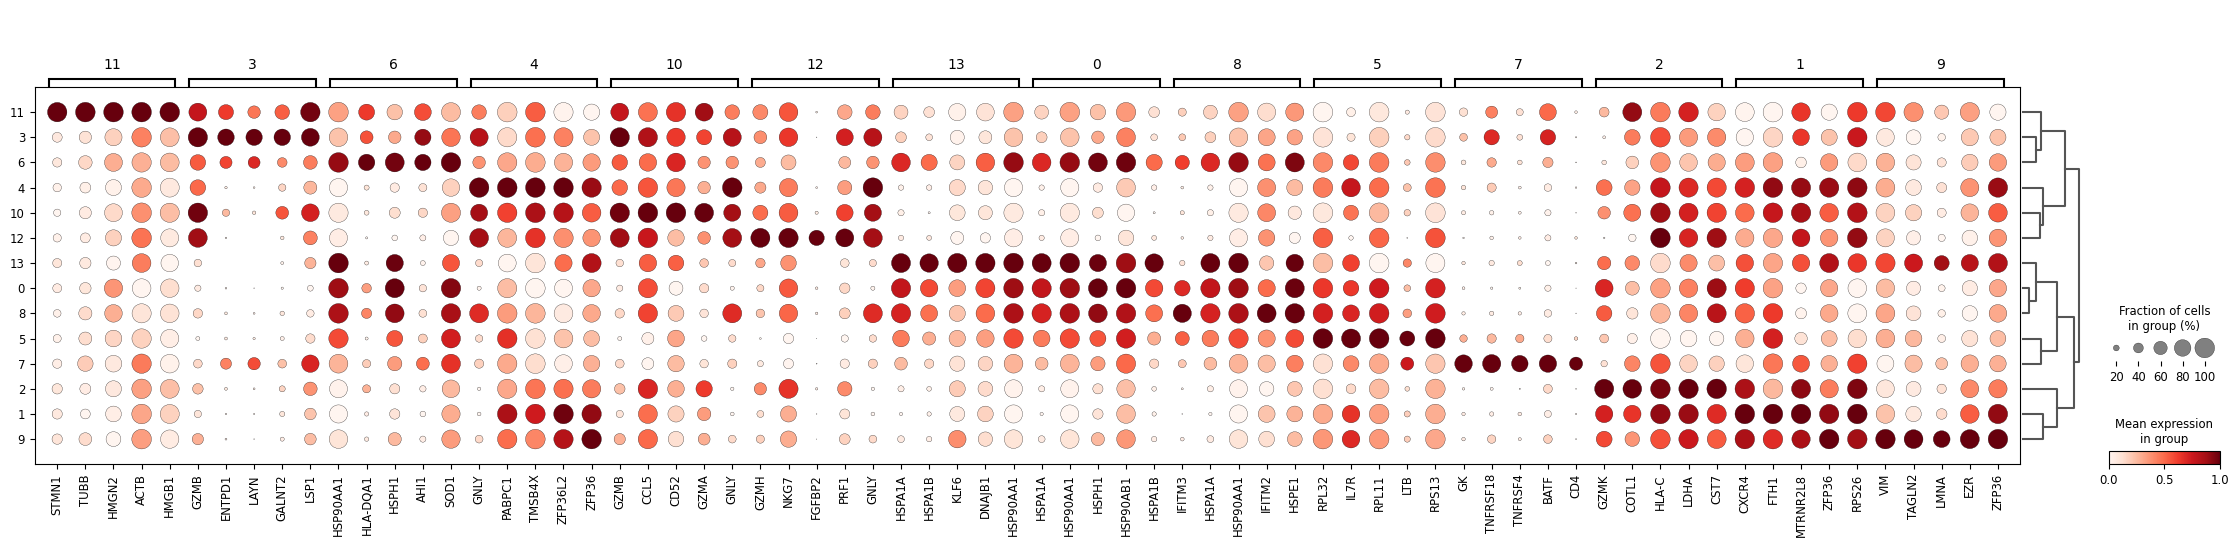

In [14]:
# visualize top 5 differentially expressed genes for each cluster
sc.pl.rank_genes_groups_dotplot(
    adata2, groupby="leiden", standard_scale="var", n_genes=5
)

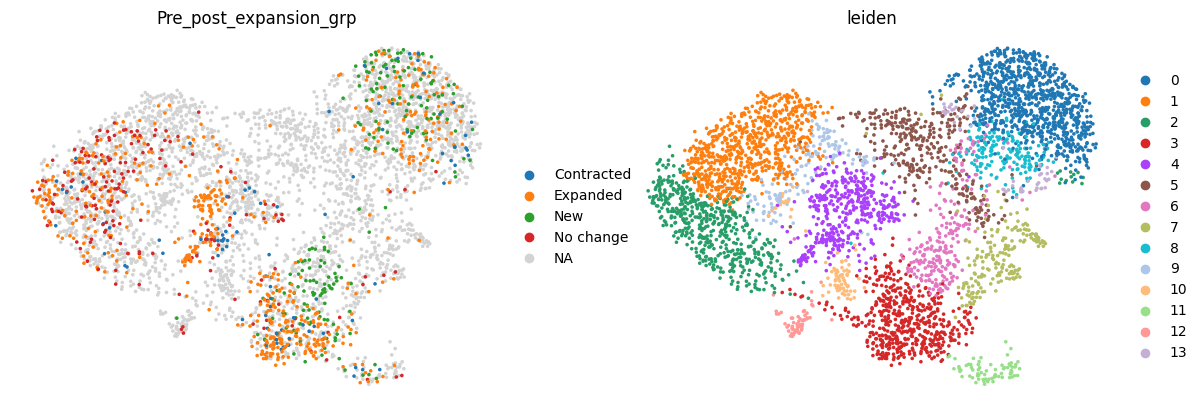

In [15]:
# TCR clone annotation 
sc.pl.umap(
    adata2,
    color=["Pre_post_expansion_grp", "leiden"],
    legend_loc="right margin",
    frameon=False,
    ncols=3,
    color_map = "Blues",
    
)

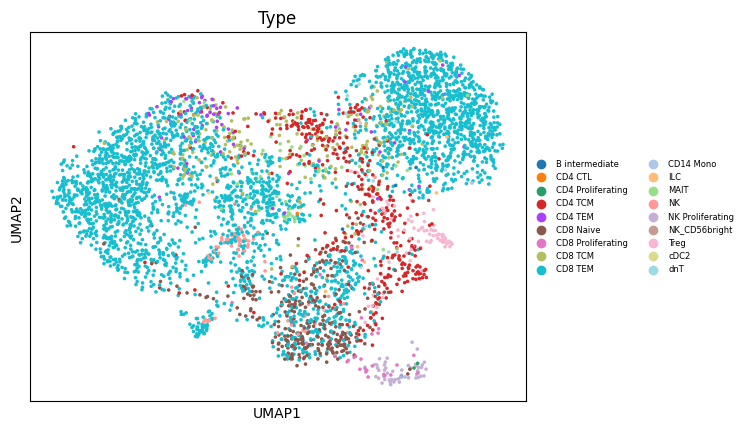

In [16]:
# Cell types (azimuth PBMC l2)
donor_umap = sc.pl.umap(adata2, color=['predicted.celltype.l2'],
    show=False,
legend_fontsize=6, frameon=True, title='Type')

In [19]:
#  cell type by cluster
obs_df = adata2.obs
pd.pivot_table(obs_df,  values = "orig.ident", index = ("leiden"), aggfunc="count", columns = "predicted.celltype.l2", margins_name="Totals", margins=True, dropna=False, fill_value="NA", observed=False)

predicted.celltype.l2,B intermediate,CD4 CTL,CD4 Proliferating,CD4 TCM,CD4 TEM,CD8 Naive,CD8 Proliferating,CD8 TCM,CD8 TEM,CD14 Mono,ILC,MAIT,NK,NK Proliferating,NK_CD56bright,Treg,cDC2,dnT,Totals
leiden,,,,,,,,,,,,,,,,,,,
0,0,0,0,6,10,0,0,24,839,1,1,1,0,0,0,0,0,5,887
1,0,0,0,16,40,1,0,53,591,0,0,4,0,0,0,0,0,1,706
2,0,0,0,5,0,8,0,0,520,0,0,0,0,0,0,0,0,0,533
3,0,0,0,30,0,235,9,4,221,0,2,0,15,0,0,3,0,0,519
4,0,2,0,1,4,0,0,10,333,0,0,23,42,0,4,0,0,0,419
5,0,0,0,175,11,2,0,69,50,0,0,17,0,0,0,9,0,3,336
6,4,0,0,46,1,44,3,23,107,0,4,1,0,0,0,2,0,4,239
7,0,0,0,87,0,12,1,1,15,0,0,1,0,0,0,68,0,3,188
8,1,0,0,0,1,2,0,9,166,0,0,4,0,0,0,0,0,0,183


In [24]:
# TCR annotation by cluster
pd.pivot_table(obs_df,  values = "orig.ident", index = ("leiden"), aggfunc="count", columns = "Pre_post_expansion_grp", margins_name="Totals", margins=True, dropna=False, fill_value="NA", observed=False)

Pre_post_expansion_grp,Contracted,Expanded,New,No change,Totals
leiden,,,,,
0,23,91,95,0,887
1,6,71,0,73,706
2,14,75,2,53,533
3,27,180,49,15,519
4,24,105,0,29,419
5,0,3,2,0,336
6,1,6,39,0,239
7,1,10,3,5,188
8,0,28,10,0,183


categories: 0, 1, 2, etc.
var_group_labels: 0, 3, 6


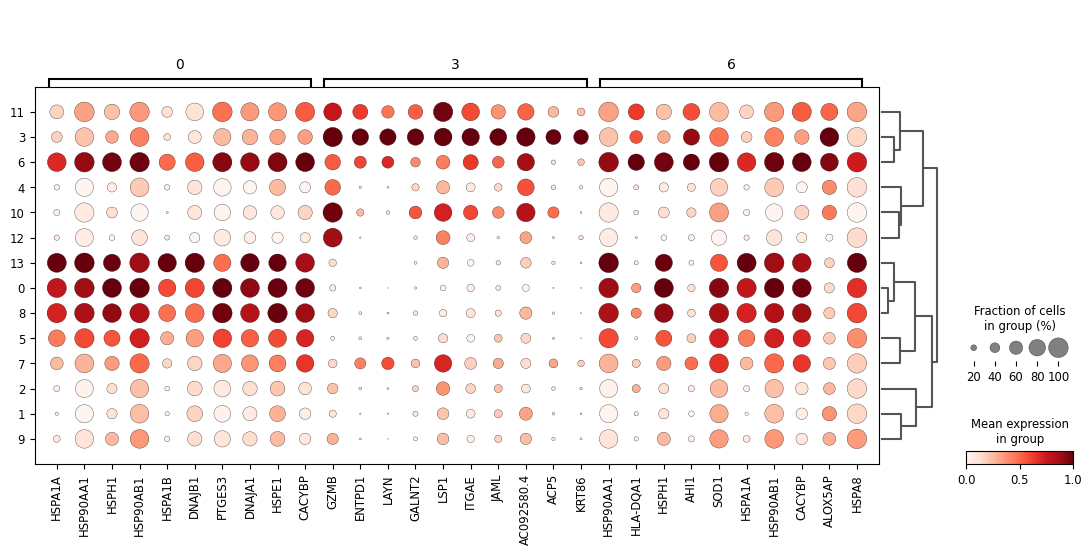

In [35]:
# Expanded enriched in cluster 3
# New enriched in 1, 3 and 6
# Top 10 genes for clusters 1, 3 and 6
sc.pl.rank_genes_groups_dotplot(
    adata2, groupby="leiden", standard_scale="var", n_genes=10, groups=["0", "3", "6"]
)